<a href="https://colab.research.google.com/github/Cosmo-ns/data-analysis-basic-kadai/blob/main/VGG16_transfer%20learning_cats%20and%20dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 転移学習とは
# 転移学習とは、すでにある学習済みの予測モデル（例：VGG16, ResNetなど）を使って、別の用途に利用する手法です。大量のデータを使って学習された予測モデルは、異なる用途でもその性能を活用できます。転移学習により、少量のデータや学習プロセスで予測モデルを効果的に構築できます。

# ファインチューニングとの違い
# ファインチューニングとは、既存の予測モデルの全体、または一部に対して、少量の新しいデータを用いて追加学習を行い、パラメータ（重みや閾値）を調整する手法です。つまり、転移学習の概念の一部を意味する言葉です。

# ただし、WEBサイトや文書によっては、以下のような意味として使われることもあります。

# 転移学習：既存の学習済みモデルの出力層エリア（終盤の全結合層の部分）を置き換え、出力層エリア以外の層のパラメータを固定して追加学習を行うこと
# ファインチューニング：既存の学習済みモデルの出力層エリアを置き換え、特にパラメータを固定することなく追加学習を行うこと

In [ ]:
# VGG16を体験してみよう
# 転移学習を実装する前に、まずは、既存の予測モデルであるVGG16が、どのようなものなのかを学びましょう。VGG16は、7章で解説したVGGNetの一種で、重みを持つ16の層で構成されたCNNです。重みを持つ層とは、畳み込み層や全結合層などを指し、プーリング層はカウントしません。

# 参考：7章 畳み込みニューラルネットワーク（CNN）とは > 7.6 転移学習 > 代表的なCNN > VGGNet

# VGG16は、高い精度で画像を分類できるモデルとして有名です。ここでは、VGG16を使って画像判定をしてみましょう。以下の順に解説します。

# VGG16の取得
# VGG16の可視化
# サンプルデータの取得
# サンプルデータの前処理
# 予測

In [ ]:
# VGG16の取得
# まず、KerasのライブラリからVGG16をインポートし、変数に代入します。引数にweights='imagenet'と指定することで、ImageNetデータセットで事前学習されたパラメータ（重みと閾値）を持つ予測モデルを読み込めます。

# ImageNetは、1400万枚以上の画像で構成される有名なデータセットです。このデータセットを利用して学習させたVGG16を、転移学習やファインチューニングに利用できます。それでは、以下のように記述して、実行してください。

# 参考：引数にweights=Noneと指定した場合、VGG16はランダムなパラメータで初期化されます。転移学習ではなく、最初から学習をする場合などに使用します。

from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')


553467096/553467096 [==============================] - 3s 0us/step


In [ ]:
# 以上で、VGG16の取得は完了です。

In [ ]:
# VGG16の可視化
# 次に、model.summary()でVGG16の予測モデルの構造を確認してみましょう。

model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# 以上のように、多数の層か積み重なったVGG16の構造を確認できます

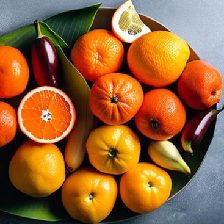

In [ ]:
# サンプルデータの取得
# 次に、予測をしたい画像データを取得しましょう。「unknown_vgg.jpg」（リンクからダウンロード可）を未知の画像データとして利用してください。ダウンロード後、Google Colaboratoryに「unknown_vgg.jpg」をアップロードします。

# Google Colaboratoryの画面左のファイルタブをクリックし、「unknown_vgg.jpg」をドラッグアンドドロップしてください。「unknown_vgg.jpg」というファイル名が表示されたら、アップロード完了です。

# 次に、load_img関数で画像を取り込みます。target_sizeパラメータで、取り込み時の画像のサイズを指定できます。なお、VGG16の可視化によって、インプットデータの構造が「任意のサンプル数×224×224×3」であることを確認できました。

# VGG16へ画像データを投入するための前処理に手間がかからないよう、target_sizeとして縦224ピクセル×横224ピクセルを指定しましょう。

from tensorflow.keras.preprocessing.image import load_img
unknown_img = load_img('/content/unknown_vgg.jpg', target_size=(224, 224))
unknown_img


In [ ]:
# 以上で、サンプルデータの取得は完了です。

In [ ]:
# サンプルデータの前処理
# 続いて、画像データを予測モデルに入力する前に、適切な形式へ変換します。まずは、img_to_array関数で画像をarray形式に変更します。

from tensorflow.keras.preprocessing.image import img_to_array
unknown_array = img_to_array(unknown_img)
unknown_array.shape


(224, 224, 3)

In [ ]:
# VGG16の可視化で確認した通り、インプットデータの構造は「任意のサンプル数×224×224×3」です。reshape関数で同じデータ構造に変換します。

unknown_array = unknown_array.reshape((1, 224, 224, 3))
unknown_array.shape


(1, 224, 224, 3)

In [ ]:
# 「任意のサンプル数×224×224×3」の形式に変換できました。

# 6,9章における画像ファイルの取り込みでは、この次のプロセスとしてスケーリング（unknown_arrayを構成する各数値を255で割る操作）を行っていました。今回は前処理方法を変更し、VGG16のpreprocess_input関数を利用して、前処理を実施します。この関数は、VGG16用に前処理が実行できる関数です。

from tensorflow.keras.applications.vgg16 import preprocess_input
unknown_array = preprocess_input(unknown_array)


In [ ]:
# 以上でサンプルデータの前処理は完了です。

In [ ]:
# 予測
# 次に、VGG16を使って画像データの予測をします。
result = model.predict(unknown_array)


1/1 [==============================] - 3s 3s/step


In [ ]:
# 次に、resultを表示します。
result


array([[1.11725527e-08, 4.89423428e-07, 3.93451494e-09, 8.92244278e-10,
        1.65926078e-10, 8.15076673e-10, 7.50457085e-10, 3.83191114e-08,
        3.24300913e-07, 2.16291235e-10, 1.27581155e-08, 2.96107139e-08,
        9.11738063e-09, 2.54531884e-09, 7.84278154e-09, 8.52190169e-07,
        3.27272403e-07, 2.91346876e-08, 9.65541531e-08, 1.64874692e-09,
        3.73937503e-09, 5.76805215e-10, 3.87632232e-10, 5.61215796e-10,
        6.26211694e-10, 5.91522253e-09, 1.81357329e-09, 2.73654210e-09,
        4.16828971e-09, 1.01353264e-08, 1.54444413e-09, 3.66637956e-08,
        1.60665725e-09, 2.15357709e-09, 6.11599660e-09, 2.35707676e-09,
        2.15744684e-08, 2.24178578e-08, 1.97570474e-10, 9.47189971e-09,
        7.22527460e-09, 1.47335633e-09, 5.07120679e-10, 1.77938120e-09,
        1.58129801e-10, 2.26414731e-09, 1.84121696e-08, 3.39397022e-09,
        1.72227441e-10, 1.42641166e-09, 1.43496381e-09, 4.02674383e-09,
        1.30943578e-09, 7.08680503e-10, 8.61743454e-10, 9.638564

In [ ]:
# 予測結果として、1000種類のカテゴリそれぞれに属する確率が表示されています。ImageNetデータセットで事前学習されたVGG16は、1000カテゴリそれぞれに属する確率を出力するように学習されているためです。なお、1000カテゴリの詳細については、以下を参照してください。
# IMAGENET 1000 Class List - WekaDeeplearning4j (waikato.ac.nz)

# decode_predictions関数を利用すると、可能性の高い上位5つのカテゴリと、そのカテゴリに属する確率が表示されます。
from tensorflow.keras.applications.vgg16 import decode_predictions
decode_predictions(result)


35363/35363 [==============================] - 0s 0us/step


[[('n07747607', 'orange', 0.8437204),
  ('n07753592', 'banana', 0.06571988),
  ('n07749582', 'lemon', 0.044244606),
  ('n07753275', 'pineapple', 0.028791558),
  ('n07716906', 'spaghetti_squash', 0.003175099)]]

In [ ]:
# 表示された結果から、インプットした画像は以下の判定結果であることが分かります。

# カテゴリ	確率
# オレンジ	約85.1%
# バナナ	約6.3%
# レモン	約4.3%
# パイナップル	約2.7%
# スパゲティスクウォッシュ	約0.3%
# 以上が、VGG16を利用した画像判定の流れとなります。

In [ ]:
# # # # VGG16を転移学習する流れのイメージ
# # # # VGG16を使って画像を判定する流れを先述しました。ImageNetで学習させたVGG16は、1000のカテゴリに分類するための予測モデルです。新しい用途（例えば犬と猫の2種類のうち、どちらであるかを分類したい場合など）に対応させるためには、どうすればよいのでしょうか。この解決策が、転移学習です。

# # # # ここでは、VGG16を転移学習する流れ（一例）のイメージを紹介します。手順は以下の通りです。順に説明していきます。

# # # # VGG16の全結合層以外の取得
# # # # 独自の全結合層の追加
# # # # 独自の全結合層部分のみの学習
# # # # 予測
# # # # 1. VGG16の全結合層以外の取得
# # # # まず、VGG16から全結合層を除外します。VGG16をインスタンス化する際に、引数にinclude_top=Falseオプションを指定することで、VGG16の全結合層以外の部分のみを取得できます。



# # # 独自の全結合層の追加
# # # 次に、独自の全結合層を追加します。Sequentialクラスを使って独自の全結合層を作成し、VGG16に追加します。この独自の全結合層は、ノード数や活性化関数を自由に設定可能です。これによって、VGG16からのアウトプットデータを、目的に応じてカスタマイズできます。



# # 独自の全結合層部分のみの学習
# # 次に、VGG16由来の部分のパラメータを固定し、独自の全結合層のパラメータのみを学習させます。これにより、VGG16の高い性能を利用しながら、目的に応じた予測モデルを構築できます。また、追加の全結合層のみを学習させることで、学習にかかる計算コストの抑制も可能です。

# ※VGG由来の部分の一部、または全部も含めて、パラメータを最適化する手法もあります。

# 予測
# 学習が完了したら、未知の画像データの判定をします。元のVGG16は1000カテゴリに属する確率を予測するモデルでしたが、1から3のプロセスを経ることで、新たなタスクに対応できるようになります。例えば、犬か猫かといった2カテゴリの判定などが可能です。

# VGG16を転移学習するイメージの解説は以上です


In [ ]:
# 転移学習用の画像データ準備
# 転移学習を行うためには、学習するための画像データが必要です。本教材では、Google Colaboratoryで転移学習のソースコードを作成します。そのため、Google ColaboratoryからアクセスしやすいGoogleドライブに学習用の画像データを格納します。

# ここでは、画像データの準備方法について解説します。画像データの準備の流れは、以下の通りです。順に解説します。

# Googleドライブ上での画像データ格納用フォルダの作成
# 画像データの取得
# Googleドライブへのアップロード


# Googleドライブ上での画像データ格納用フォルダの作成
# Googleドライブ上に、画像データの保管フォルダを用意します。以下のようなフォルダ構成を作成します。


# my drive---date train--dog
#          |           |
#          |           |--cat
#          |
#          |--date_test--dog
#                      |
#                      |--cat

# まずは、マイドライブの最上位の階層に、学習データ保管用の「data_train」と、テストデータ保管用の「data_test」という名称のフォルダを作成してください。
# 作成した「data_train」フォルダの内部に、「dog」と「cat」という名称のフォルダを作成します。
# 同様に「data_test」フォルダ内部にも、「dog」と「cat」という名称のフォルダを作成します。
# 以上で、Googleドライブ上での画像データ格納用フォルダの作成は完了です。



In [ ]:
# 画像データの取得
# 次に、犬と猫の画像データを用意します。MicrosoftのサイトのDawnloadボタンから、「kagglecatsanddogs_5340.zip」ファイルをダウンロードできます。

# ダウンロードした「kagglecatsanddogs_5340.zip」ファイルを解凍すると、その内部のCatフォルダに12,500枚の猫の写真（0.jpg, 1.jpg, …12499.jpg）と、Dogフォルダに12,500枚の犬の写真（0.jpg, 1.jpg, …12499.jpg）が格納されています。以上で、画像データの取得は完了です。

In [ ]:
# Googleドライブへのアップロード
# ダウンロードした犬と猫の画像データを、Googleドライブにアップロードします。犬と猫の画像データを、それぞれ以下のように格納してください。

# ダウンロードした画像	格納先
# Dogフォルダの0.jpg～255.jpgの計256ファイル	マイドライブ > data_train > dog
# Catフォルダの0.jpg～255.jpgの計256ファイル	マイドライブ > data_train > cat
# Dogフォルダの256.jpg～319.jpgの計64ファイル	マイドライブ > data_test > dog
# Catフォルダの256.jpg～319.jpgの計64ファイル	マイドライブ > data_test > cat

# これらの画像データは、次章の転移学習で利用します。以上で、転移学習用の画像データの準備は完了です。

In [ ]:
# 引き続き、学習済みの予測モデルであるVGG16を活用した転移学習を実施し、犬と猫の画像を識別する予測モデルの構築方法を学びます。本章では、以下を目標にして学習します。

# ImageDataGeneratorを利用した学習データのセットアップ方法を学ぶこと
# VGG16を活用した転移学習の実施方法を学ぶこと
# 予測モデルの保存方法と読み込み方法を学ぶこと
# 本章ではまず、ImageDataGeneratorと呼ばれるKerasのクラスを利用して、前章で準備した学習データのセットアップを行います。その後、[VGG16](#heading=h.a7st29e4udn1)をカスタマイズし転移学習を実施します。それでは、VGG16の予測モデルを、異なるタスクに活用する転移学習のプロセスを体験していきましょう。

In [ ]:
# 転移学習の実行の流れ
# はじめに、VGG16を転移学習して犬と猫の画像分類をする、本章全体の流れを記載します。順に解説していきます。

# GPUへの切り替え
# 乱数の固定
# Googleドライブのマウント
# 学習データのセットアップ
# VGG16の全結合層以外の取得
# 予測モデル（全結合層を除くVGG16）の可視化
# VGG16のSequentalモデルへの変換
# VGG16のパラメータ凍結
# 独自の全結合層の追加
# 予測モデル（VGG16 + 独自の全結合層）の可視化
# 誤差関数、最適化方法、評価指標の設定
# 学習
# 評価
# 予測

#####
#GPU#
#####

In [ ]:
# 乱数の固定
# 実験の再現性を高めるために、乱数を固定します。Kerasのutilsモジュールのset_random_seed関数によって、Pythonのrandomモジュール、Numpyのrandomモジュール、TensorFlowのrandomモジュールで発生する乱数を固定可能です。

from tensorflow.keras import utils
utils.set_random_seed(0)


In [ ]:
# Googleドライブのマウント
# 前章で準備したGoogleドライブ上の画像ファイルにアクセスするため、Google Colaboratory上でGoogleドライブのマウントを行います。以下の手順で実施してください。

# Google Colaboratoryの画面左のファイルタブをクリック
# Googleドライブのマークをクリック
# ポップアップが出現
# Googleドライブに接続をクリック
# driveのフォルダが表示


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# 学習データのセットアップ
# 前章でGoogleドライブにアップロードした犬と猫の画像データを読み込むために、KerasのImageDataGeneratorというクラスを使用します。ここでは、ImageDataGeneratorのセットアップ方法について解説します。

# ImageDataGeneratorとは
# ImageDataGeneratorは、特定のフォルダに格納されている画像データを、前処理しながら、予測モデルに流し込む機能を提供します。まずはImageDataGeneratorをインポートします。

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [31]:
# 画像データの加工方法の設定
# ImageDataGeneratorのインスタンスを作成します。パラメータを指定することで、画像データの加工や複製方法の設定が可能です。今回は、以下のパラメータを指定します。

# パラメータ	説明
# rescale	画像データが持つピクセル値をスケーリングできます。今回は、1/255を指定します。
# validation_split	学習データの一部を、バリデーションデータとして使用する割合を指定します。今回は、25%を指定します。
# ※補足：その他、以下のようなパラメータの指定も可能です。主に学習データの複製に利用するパラメータです。

# パラメータ	説明
# rotation_range	指定した範囲内で、画像をランダムに回転させます。
# width_shift_range / height_shift_range	指定した範囲内で、画像を水平または垂直にシフトさせます。
# zoom_range	指定した範囲内で、画像をランダムにズームさせます。
# それでは、以下のように記述して、実行してください。

datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)


In [32]:
# 画像データの流し込み方法の設定
# 次に、ジェネレータを作成します。ジェネレータとは、一定数の画像データを、繰り返し予測モデルへ流し込む機能を持ったオブジェクトです。

# flow_from_directoryメソッドで、ジェネレータを作成できます。第1引数に、流し込みたい画像の格納先フォルダを指定します。また、以下のパラメータも指定可能です。

# subset：「training」または「validation」を指定します。これは、ImageDataGeneratorのインスタンス化の際に、validation_splitパラメータで、バリデーションデータを確保した場合にのみ利用するものです。
# target_size：画像をリサイズするためのパラメータです。今回は、(256, 256)と指定します。これによって、流し込み時に画像が256ピクセル×256ピクセルにリサイズされます。
# batch_size：一度に予測モデルに流し込む画像データの数を指定します。今回は64を指定します。
# まずは、学習データのジェネレータを作成します。

train_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/data_train',
        subset='training',
        target_size=(256, 256),
        batch_size=64)


Found 386 images belonging to 2 classes.


In [33]:
# 実行結果として「Found 384 images（384ファイル見つかった）」と表示されました。これは、data_trainフォルダに含まれる画像514枚（犬256枚＋猫256枚）のうち75%（25%はバリデーションデータ）である384枚が検知されたことを意味します。

# また「belonging to 2 classes（2クラスに属する）」ことも表示されています。これは、犬と猫の2つのカテゴリが認識されていることを意味します。前章の画像データの準備の際、data_trainフォルダに、dogフォルダとcatフォルダを作成して、それぞれに画像を格納しました。このフォルダ構成によって、ImageDataGeneratorが自動的にどの画像が犬で、どの画像が猫なのかを認識するようになります。

# なお、転移学習において、犬と猫のカテゴリは、数値ラベルとして表現されます。どちらのカテゴリが、どの数値ラベルであるかは、class_indices属性で確認できます。

train_generator.class_indices


{'cat': 0, 'dog': 1}

In [34]:
# この結果から、猫は数値ラベル0、犬は数値ラベル1で表現されることを確認できました。

# 学習データのジェネレータと同様に、バリデーションデータのジェネレータも作成しましょう。

val_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/data_train',
        subset='validation',
        target_size=(256, 256),
        batch_size=64)


Found 128 images belonging to 2 classes.


In [35]:
# 続いて、テストデータのジェネレータも作成しましょう。なお、テストデータは、「training」と「validation」の区分がないため、subsetパラメータの指定は不要です。

test_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/data_test',
        target_size=(256, 256),
        batch_size=64)


Found 128 images belonging to 2 classes.


In [ ]:
# 以上で、学習データのセットアップは完了です。

In [36]:
# VGG16の全結合層以外の取得
# 次に、VGG16の全結合層を取り除くため、include_top=Falseオプションを指定してVGG16を取得します。また、input_shape=(256, 256, 3)も指定します。これによって、VGG16へインプットできる画像のサイズを、ジェネレータ作成の際に設定した画像サイズ「256ピクセル×256ピクセル」に揃えることが可能です。


from tensorflow.keras.applications.vgg16 import VGG16
vgg16_without_fc = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# 以上で、VGG16の全結合層以外の取得は完了です。

In [37]:
# 予測モデル（全結合層を除くVGG16）の可視化
# 取得したVGG16の構造を確認するために、summary()メソッドを使って可視化します。

vgg16_without_fc.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# 前章でVGG16を取得したときには存在した、最後の全結合層が除外されていることが確認できます。

In [38]:
# VGG16のSequentalモデルへの変換
# 次に、VGG16をSequentialモデルに変換します。Sequentialモデルとは、Sequentialクラスを用いて予測モデルを定義する形式です。5, 6, 8, 9章で定義していた方法が、これに当たります。一方で、取得したVGG16は、Functional APIという異なる形式でモデルの構造が定義されています。

# VGG16をSequentialモデルに変換する理由は、独自の層を簡潔に追加できるようにするためです。まずSequentialクラスをインスタンス化します。次に、VGG16の各層を1つずつ、addメソッドで追加していきます。これにより、VGG16モデルを、Sequentialモデルへ変換できます。

from tensorflow.keras.models import Sequential
model = Sequential()
for layer in vgg16_without_fc.layers:
    model.add(layer)



In [39]:
# 問題なく変換できたか、summary()メソッドを使って可視化します。

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [ ]:
# 最初のInputLayer（入力層）のみ、表示される・表示されないという仕様上の差はありますが、各層の構成は変化していないことを確認できます。


In [40]:
# VGG16のパラメータ凍結
# 次に、VGG16由来の層のパラメータを変更しないようにするため、各層のtrainable属性をFalseに設定します。この設定によって、学習をしてもVGG16由来の層のパラメータはそのままの値で保持され、後続プロセスで結合する独自の全結合層のパラメータのみが、学習の対象となります。

# それでは、各層のtrainable属性をFalseに設定し、パラメータを凍結します。

for layer in model.layers:
    layer.trainable = False


In [41]:
# 独自の全結合層の追加
# 次に、全結合層を取り除いたVGG16に、犬と猫を分類するための独自の全結合層を追加します。以下のステップで追加します。

# 全結合層を取り除いたVGG16からの出力されるデータを、Flattenクラスを使用して1次元に変換します。
# 独自の全結合層を隠れ層として追加します。今回はノード数を256、活性化関数をReLUとします。ノード数には明確な推奨値がなく、後続の学習や評価プロセスの結果を見ながら、試行錯誤して決定する項目です。
# 独自の全結合層を出力層として追加します。犬と猫の分類をするため、ノード数は2、活性化関数をソフトマックス関数とします。


from tensorflow.keras.layers import Flatten, Dense
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

# 以上で、独自の全結合層の追加は完了です。

In [42]:
# 予測モデル（VGG16 + 独自の全結合層）の可視化
# それでは、summary()メソッドを使って、VGG16と独自の全結合層を結合したモデルの構造を確認します。

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [ ]:
# 1次元データへの変更プロセスであるFlattenと、2つの全結合層が追加されていることを確認できました。さらに、注目してほしいのが、Total param（全パラメータ数）23,104,066のうち、14,714,688がNon-trainnable param（学習しないパラメータ）となっている部分です。VGG16のパラメータ凍結で実施した処理が、反映されていることを示しています。

# また、追加した独自の全結合層のパラメータの合計（8,388,864+514）と、学習対象のパラメータを意味するTrainable paramsの値が、共に8,389,378で一致していることも確認できます。つまり、新しく追加した全結合層のみが学習対象であることが示されています。

In [43]:
# 誤差関数、最適化方法、評価指標の設定
# 次は、誤差関数、最適化方法、評価指標の設定をします。誤差関数として二値交差エントロピー誤差（Binary Cross-Entropy Error）を使用します。二値交差エントロピー誤差は、2つのカテゴリ（今回は犬と猫）を分類する際に一般的に利用される誤差関数です。compileメソッドの引数で、loss='binary_crossentropy'と指定すれば適用されます。

# また、最適化手法としてAdamを、評価指標として正解率（accuracy）を指定します。これらの設定は、5, 6, 8, 9章で実施したニューラルネットワークやCNNにおける設定時と、同様の理由に基づきます。

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='accuracy')


In [ ]:
# 以上で、誤差関数、最適化方法、評価指標の設定は完了です。

In [44]:
# 学習
# 学習データとバリデーションデータを使って予測モデルを学習させます。この際に、以下の引数を指定します。

# train_generator：学習データを供給するデータジェネレータを指定します。これにより、モデルに対して学習データの流し込みが行われます。
# validation_data=val_generator：バリデーションデータとして、val_generatorを指定します。これによって、学習中にバリデーションデータによる損失関数と正解率の推移をモニタリングできます。
# epochs：学習をするエポック数を指定します。今回は5エポックで学習します。

# なお、バッチサイズはジェネレータ作成時に設定した64が適用されます。

history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5)


Epoch 1/5
7/7 [==============================] - 104s 13s/step - loss: 3.3415 - accuracy: 0.5699 - val_loss: 2.4330 - val_accuracy: 0.5000
Epoch 2/5
7/7 [==============================] - 4s 478ms/step - loss: 0.9956 - accuracy: 0.6580 - val_loss: 0.3908 - val_accuracy: 0.9219
Epoch 3/5
7/7 [==============================] - 4s 585ms/step - loss: 0.4638 - accuracy: 0.8446 - val_loss: 0.5051 - val_accuracy: 0.8125
Epoch 4/5
7/7 [==============================] - 4s 561ms/step - loss: 0.2770 - accuracy: 0.9145 - val_loss: 0.2552 - val_accuracy: 0.9297
Epoch 5/5
7/7 [==============================] - 4s 480ms/step - loss: 0.1426 - accuracy: 0.9637 - val_loss: 0.1904 - val_accuracy: 0.9219


In [ ]:
# 以上で、予測モデルの学習は完了です。

<Axes: >

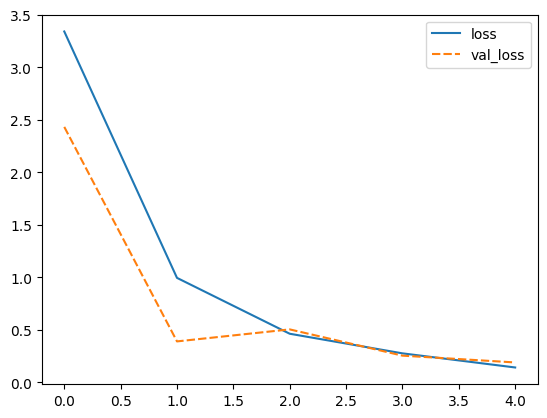

In [45]:
# 学習履歴の可視化
# 次に、学習過程での正解率と損失の変化を可視化し、過学習や学習不足を確認しましょう。fit関数の戻り値であるHistoryオブジェクトのhistory属性に、学習履歴の推移が格納されています。DataFrameに変換し、seabornのlineplotメソッドを利用して、損失関数（loss, val_loss）の推移を可視化します。

import pandas as pd
import seaborn as sns
df = pd.DataFrame(history.history)
sns.lineplot(data=df[['loss', 'val_loss']])


<Axes: >

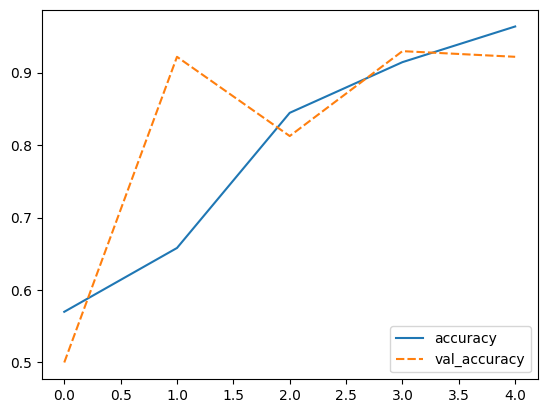

In [46]:
# 同様に、正解率（accuracy, val_accuracy）の推移も可視化します。

sns.lineplot(data=df[['accuracy', 'val_accuracy']])


In [ ]:
# 損失関数と正解率の推移の曲線から、学習データ、バリデーションデータともに良好な数値で安定しており、十分に学習できていると判断できます。

In [47]:
# 評価
# 次に、学習済み予測モデルの評価をしましょう。Sequentialクラスのevaluateメソッドを使って評価を実行できます。この際に引数にはテストデータのジェネレータを指定します。

model.evaluate(test_generator)


2/2 [==============================] - 20s 19s/step - loss: 0.3408 - accuracy: 0.8438


[0.34082669019699097, 0.84375]

In [ ]:
# テストデータによる評価結果は、損失関数（loss）が約0.3113であり、正解率（accuracy）は約0.8438です。この評価結果が十分であれば、次のステップに進みます。そうでなければ、予測モデルの構造や損失関数、最適化手法、ハイパーパラメータなどを見直して、再度学習をする必要があります。

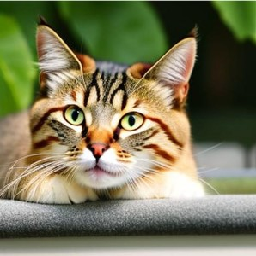

In [48]:
# 予測
# 最後に、実際に犬もしくは猫の画像を投入し、正しく判定できるかを確認しましょう。予測は、以下の順で進めます。

# 画像ファイルの取り込み
# 画像ファイルの前処理
# 予測
# 1. 画像ファイルの取り込み
# まずは、予測したい画像を取り込みます。「unknown_cat.jpg」（リンクからダウンロード可）を未知の画像データとして利用してください。ダウンロード後、Google Colaboratoryに「unknown_cat.jpg」をアップロードします。

# Google Colaboratoryの画面左のファイルタブをクリックし、「unknown_cat.jpg」をドラッグアンドドロップしてください。「unknown_cat.jpg」というファイル名が表示されたら、アップロード完了です。

# 次に、Kerasのpreprocessingモジュールのload_img関数をインポートし、画像を取り込みます。target_sizeパラメータで、取り込み時の画像のサイズを指定できます。ジェネレータ作成の際に設定したサイズに合わせ、縦256ピクセル×横256ピクセルを指定しましょう。

from tensorflow.keras.preprocessing.image import load_img
unknown_img = load_img('unknown_cat.jpg', target_size=(256, 256))
unknown_img


In [49]:
# 画像ファイルの前処理
# 次に画像ファイルの前処理を行います。画像データをarray形式に変換し、予測モデルのインプットデータの構造である「任意のサンプル数×縦256ピクセル×横256ピクセル×3チャネル」の形状に揃えましょう。その次に、ImageDataGeneratorのインスタンス作成時の設定と同様に、256で割ってスケーリングを行います。

from tensorflow.keras.preprocessing.image import img_to_array

# array形式に変換
unknown_array = img_to_array(unknown_img)

# データ構造の変換
unknown_array = unknown_array.reshape((1, 256, 256, 3))

# スケーリング
unknown_array = unknown_array/255


In [50]:
# 予測
# 最後に、Sequentialクラスのpredictメソッドを利用して、取り込んだ画像データが、犬・猫のどちらのカテゴリであるかの予測をします。

model.predict(unknown_array)


1/1 [==============================] - 1s 945ms/step


array([[1.0000000e+00, 1.7855056e-09]], dtype=float32)

In [ ]:
# ジェネレータ作成時に確認した通り、猫は数値ラベル0、犬は数値ラベル1で表現されます。したがって、出力結果から、猫である確率がほぼ100%、犬である確率がほぼ0%であると予測できます。

# VGG16を転移学習させ、犬と猫の画像を判定する流れは以上となります。

In [51]:
# 予測モデルの保存と読み込み
# 学習済みの予測モデルは、保存して、必要に応じて再利用可能です。ここでは、予測モデルの保存方法と読み込み方法を解説します。

# 予測モデルの保存
# save_model関数を利用すると、学習済み予測モデルの保存が可能です。save_model関数の第1引数に、予測モデルを代入している変数名を、第2引数にファイル名称を指定します。ファイル名の拡張子は「.h5」とします。

from tensorflow.keras.models import save_model
save_model(model, 'model.h5')


<ipython-input-51-e586a2aeaa5c>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'model.h5')


In [ ]:
# 実行後、Google Colaboratoryの画面左のファイルツリーで、保存したモデルを確認できます。ファイル名右側の三点リーダからダウンロードもできます。以上が、予測モデルの保存方法です。



In [53]:
# 予測モデルの読み込み
# load_model関数を使うと、保存した予測モデルを読み込み、再利用できます。

from tensorflow.keras.models import load_model
loaded_model = load_model('model.h5')


In [54]:
# 読み込んだモデルを利用して、先程犬猫判定した画像を、再度予測してみましょう。

loaded_model.predict(unknown_array)


1/1 [==============================] - 0s 227ms/step


array([[1.0000000e+00, 1.7855056e-09]], dtype=float32)

In [ ]:
# 読み込んだモデルでも、犬猫の画像判定が可能であることを確認できました。予測モデルの保存と読み込みの解説は以上です。